In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def addHour(row):
    if row[-3] == 'EST':
        row[0] = row[0] + pd.to_timedelta(1, unit='h')
        row[-3] = 'EDT'
    return row

dataRaw = pd.read_csv('./data/waterLevel.txt', skiprows = np.arange(29), delimiter = '	', names = ['USGS', 'code', 'time', 'timeZone', 'heightFeet', 'provisional']) 
dataRaw = dataRaw.drop(['USGS', 'code'], axis = 1)
dataRaw['time'] = pd.to_datetime(dataRaw['time'])
dataRaw = dataRaw.apply(addHour, axis = 1)
data = dataRaw[dataRaw['provisional'] == 'A']

# LSTM-based water level prediction

## Data preprocessing

In [3]:
# params
train_split_fraction = 0.7
val_split_fraction = 0.15
past = 28
predict_length = 2
learning_rate = 0.001
batch_size = 256
epochs = 10

# split data
train_split = int(train_split_fraction * int(data.shape[0]))
val_split = int(val_split_fraction * int(data.shape[0]))
train_data = data.loc[0 : train_split - 1]
val_data = data.loc[train_split : (train_split + val_split - 1)]
test_data = data.loc[(train_split + val_split) : ]

# build x and y fro each dataset
def makeSequence(iterable, lenSequence):
    sequences = []
    sequence = []
    for one in iterable:
        sequence.append(one)
        if len(sequence) == lenSequence:
            sequences.append(sequence)
            sequence = sequence[1:]
    return sequences

x_train = train_data['heightFeet'].values
y_train = data.iloc[past : (train_split + predict_length)]['heightFeet'].values
x_train_sequences = np.array(makeSequence(x_train, past))
y_train_sequences = np.array(makeSequence(y_train, predict_length))

x_val = val_data['heightFeet'].values
y_val = data.iloc[(train_split + past) : (train_split + val_split + predict_length)]['heightFeet'].values
x_val_sequences = np.array(makeSequence(x_val, past))
y_val_sequences = np.array(makeSequence(y_val, predict_length))

x_test = test_data.iloc[: -predict_length]['heightFeet'].values
y_test = data.iloc[(train_split + val_split + past) : ]['heightFeet'].values
x_test_sequences = np.array(makeSequence(x_test, past))
y_test_sequences = np.array(makeSequence(y_test, predict_length))

print('shape of X array for training:', x_train_sequences.shape)
print('shape of Y array for training:', y_train_sequences.shape)

shape of X array for training: (116607, 28)
shape of Y array for training: (116607, 2)


## Modeling and training

In [4]:
layer_input = keras.layers.Input(shape=(x_test_sequences.shape[1], 1))
layer_lstm = keras.layers.LSTM(16)(layer_input)
layer_output = keras.layers.Dense(2)(layer_lstm)

model = keras.Model(inputs = layer_input, outputs = layer_output)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 1,186
Trainable params: 1,186
Non-trainable params: 0
_________________________________________________________________


In [5]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    x = x_train_sequences,
    y = y_train_sequences,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val_sequences, y_val_sequences),
    callbacks = [es_callback, modelckpt_callback],
)

Epoch 1/10
455/456 [============================>.] - ETA: 0s - loss: 203.8177
Epoch 00001: val_loss improved from inf to 81.22280, saving model to model_checkpoint.h5
456/456 [==============================] - 5s 11ms/step - loss: 203.6822 - val_loss: 81.2228
Epoch 2/10
453/456 [============================>.] - ETA: 0s - loss: 41.4006
Epoch 00002: val_loss improved from 81.22280 to 19.33915, saving model to model_checkpoint.h5
456/456 [==============================] - 5s 10ms/step - loss: 41.2909 - val_loss: 19.3392
Epoch 3/10
455/456 [============================>.] - ETA: 0s - loss: 12.7124
Epoch 00003: val_loss improved from 19.33915 to 6.18278, saving model to model_checkpoint.h5
456/456 [==============================] - 5s 10ms/step - loss: 12.7101 - val_loss: 6.1828
Epoch 4/10
451/456 [============================>.] - ETA: 0s - loss: 8.1081
Epoch 00004: val_loss improved from 6.18278 to 4.09589, saving model to model_checkpoint.h5
456/456 [==============================] - 5

## Prediction and evaluation

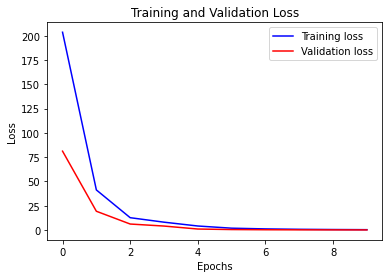

In [6]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [65]:
# mean absolute error
predictions = model.predict(x_test_sequences)
meanError = np.mean(np.absolute(y_test_sequences - predictions))
meanError

0.23077698857288148

Text(0.5, 1.0, 'Prediction vs Ground truth')

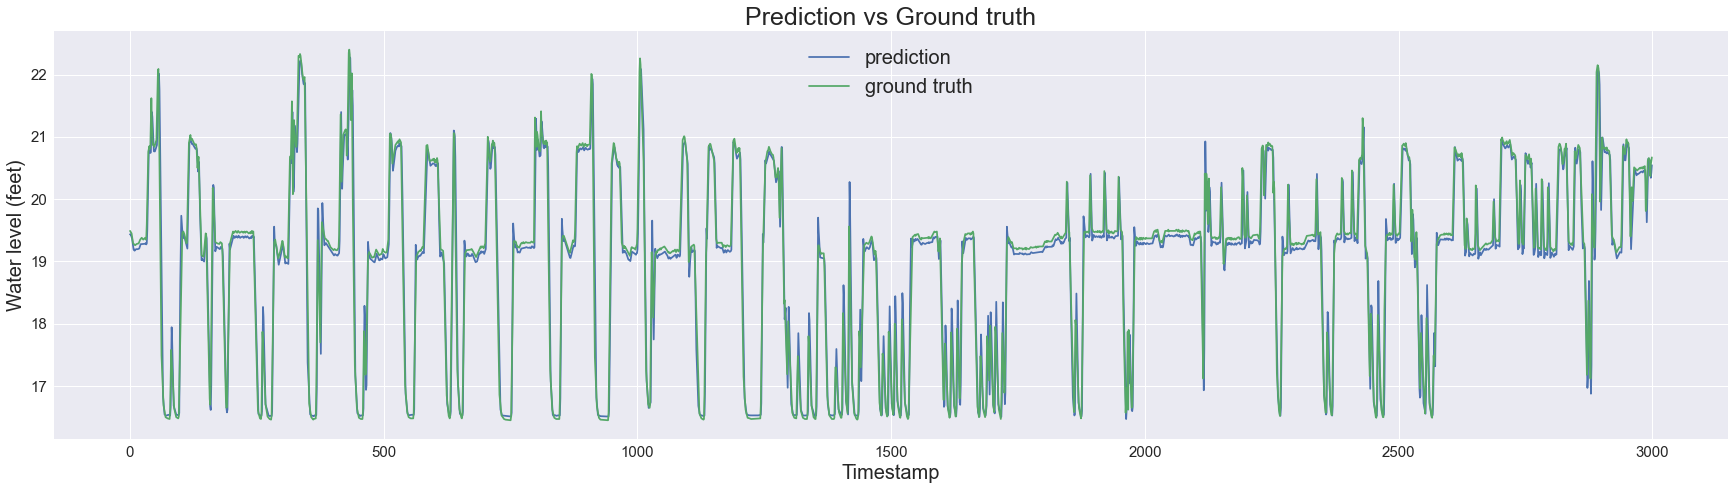

In [80]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(30, 7.5))
start = 10000
end = 13000
t = range(end - start)
ax.plot(t, predictions[start:end,0], label = 'prediction')
ax.plot(t, y_test_sequences[start:end,0], label = 'ground truth')
ax.set_xlabel('Timestamp', fontsize = 20)
ax.set_ylabel('Water level (feet)', fontsize = 20)
ax.legend(fontsize = 20)
ax.tick_params(axis='both', labelsize = 15)
ax.set_title('Prediction vs Ground truth', fontsize = 25)

Text(0.5, 1.0, 'Absolute error of prediction (feet)')

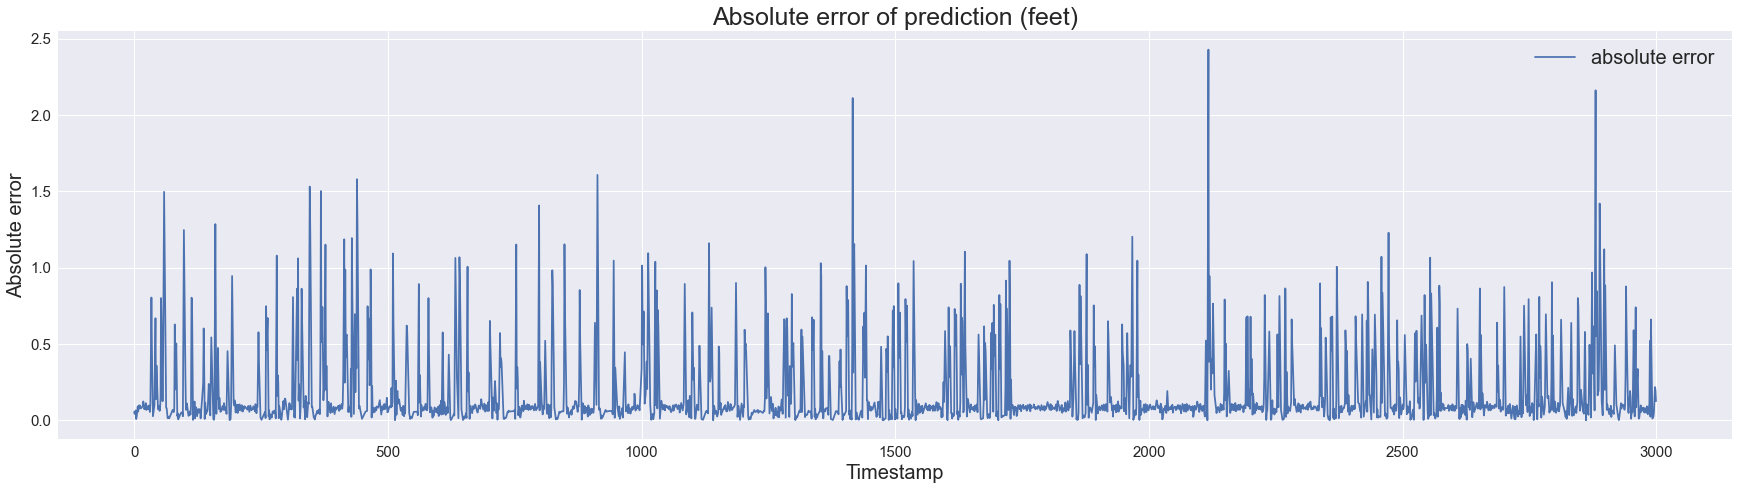

In [81]:
plt.style.use('seaborn')
fig1, ax1 = plt.subplots(figsize=(30, 7.5))
#t1 = range(predictions.shape[0])
start1 = 10000
end1 = 13000
t1 = range(end1 - start1)
ax1.plot(t1, np.absolute(predictions[:,0] - y_test_sequences[:,0])[start1:end1], label = 'absolute error')
ax1.set_xlabel('Timestamp', fontsize = 20)
ax1.set_ylabel('Absolute error', fontsize = 20)
ax1.legend(fontsize = 20)
ax1.tick_params(axis='both', labelsize = 15)
ax1.set_title('Absolute error of prediction (feet)', fontsize = 25)